In [8]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/openfoamDATA/all_data_vanKarman.hdf5' all_data.hdf5

cp: cannot stat '/content/drive/MyDrive/openfoamDATA/all_data_vanKarman.hdf5': No such file or directory


In [9]:
!cp '/content/drive/MyDrive/all_data_vanKarman_reduced.hdf5' all_data.hdf5

In [1]:
from numba import njit
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import math


# Read and prepare data

# read data with x,y

In [2]:
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import numpy as np
import math
from numba import njit


def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:5, 0:50, ...]
    y = hdf5_file["sim_data"][:5, 1:51, ...]
    sim_no = hdf5_file["sim_no"][:5, 0]
    hdf5_file.close()

    times = 50

    @njit
    def index(array, item):
      for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.
  
    max_0 = np.max( x[...,0] )
    max_1 = np.max( x[...,1] )
    max_2 = np.max( x[...,2] )

    x_mod = x * (x!=-100)

    min_0 = np.min( x_mod[...,0] )
    min_1 = np.min( x_mod[...,1] )
    min_2 = np.min( x_mod[...,2] )

    max_min_list = [max_0, max_1, max_2 , min_0 , min_1 ,min_2]


    y = y[...,0:3]

    for i in range(y.shape[0]):
      indice = index(y[i,0,:,0] , -100.0 )[0]
      if np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]) != 0:
        y[i,:,:indice,0] = (y[i,:,:indice,0] - np.ones((y[i,:,:indice,0].shape))* min_0 )/(max_0 - min_0)
        y[i,:,:indice,1] = (y[i,:,:indice,1] - np.ones((y[i,:,:indice,1].shape))* min_1 )/(max_1 - min_1)
        y[i,:,:indice,2] = (y[i,:,:indice,2] - np.ones((y[i,:,:indice,2].shape))* min_2 )/(max_2 - min_2)

    for i in range(x.shape[0]):
      indice = index(x[i,0,:,0] , -100.0 )[0]
      if np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]) != 0:
        x[i,:,:indice,0] = (x[i,:,:indice,0] - np.ones((x[i,:,:indice,0].shape))* min_0 )/(max_0 - min_0)
        x[i,:,:indice,1] = (x[i,:,:indice,1] - np.ones((x[i,:,:indice,1].shape))* min_1 )/(max_1 - min_1)
        x[i,:,:indice,2] = (x[i,:,:indice,2] - np.ones((x[i,:,:indice,2].shape))* min_2 )/(max_2 - min_2)


    t = np.zeros(shape=(x.shape[0],x.shape[1],x.shape[2] ,1))

    for i in range(x.shape[0]):
      t[i,:,:,:] = np.ones((x.shape[1],x.shape[2],1)) * (i - math.floor(i/(times+1))*(times+1)+1)

    x = np.concatenate((x,t), axis=3)



    total_sim = x.shape[0]

    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]


    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, max_min_list

hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test, max_min_list = read_dataset(hdf5_path, split=0.9, print_shape=True)


assert not np.any(np.isnan(x_train))
assert not np.any(np.isnan(y_train))

assert not np.any(np.isnan(x_test))
assert not np.any(np.isnan(y_test))


total_sim: 5
x_train.shape: (4, 50, 4000, 6)
y_train.shape: (4, 50, 4000, 3)
x_test.shape: (1, 50, 4000, 6)
y_test.shape: (1, 50, 4000, 3)



# Loss function

x_train : (n,50,150,5)

last collumn: 0-ux 1-uy 2-p 3-x 4-y

In [ ]:
from numpy import random
@tf.function
def f_model(train):
  
  dtype = "float32"

  #num = 32

  #idxs=random.randint(train.shape[0], size=(num)) 
  #idxs = np.array(idxs)
  
  #train = train[idxs,:,:]
  #ux = train[:,:,0]
  #uy = train[:,:,1]
  #p = train[:,:,2]
  x = tf.convert_to_tensor(train[:,:,0], dtype=dtype)
  y = tf.convert_to_tensor(train[:,:,1], dtype=dtype)
  t = tf.convert_to_tensor(train[:,:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    #X_f = tf.stack([ux , uy , p , x, y , t], axis=2)
    X_f = tf.stack([x, y , t], axis=2)

    y_pred = model(X_f)

    ux = y_pred[:,:,0]
    uy = y_pred[:,:,1]
    p = y_pred[:,:,2]

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  ux_t = tape.gradient(ux,t)
  uy_t = tape.gradient(uy,t)

  ux_xx = tape.gradient(ux_x,x)
  ux_yy = tape.gradient(ux_y,y)

  uy_xx = tape.gradient(uy_x,x)
  uy_yy = tape.gradient(uy_y,y)

  p_x = tape.gradient(p,x)
  p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.square(res)
  NSx_residual = tf.square(residual_NS_x)
  NSy_residual = tf.square(residual_NS_y)

  return cont_residual, NSx_residual, NSy_residual

In [ ]:
def eq_loss():
  def equation_loss(y_true, y_pred, x):

    res, residual_NS_x, residual_NS_y = f_model(x)

    ux = y_true[:,:,0]
    uy = y_true[:,:,1]
    p = y_true[:,:,2]

    ux_pred = y_pred[:,:,0]
    uy_pred = y_pred[:,:,1]
    p_pred = y_pred[:,:,2]
    
    return   (tf.square(tf.square(ux - ux_pred)) + \
                  tf.square(tf.square(uy - uy_pred)) + \
                  tf.square(tf.square(p - p_pred))) * 1 + \
                  (res + residual_NS_x + residual_NS_y)
  return equation_loss

# Dense model - flat

In [ ]:
#rearrange data
x_train = x_train.reshape(x_train.shape[0]*50*250,3)
y_train = y_train.reshape(y_train.shape[0]*50*250,3)
x_test = x_test.reshape(x_test.shape[0]*50*250,3)
y_test = y_test.reshape(y_test.shape[0]*50*250,3)

ValueError: ignored

In [ ]:
def dense_model():
  input_layer = tf.keras.Input (3)
  #x = tf.keras.layers.Masking(mask_value=0.)(input_layer)
  x = tf.keras.layers.Dense(10, activation='relu')(input_layer)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  output_layer = tf.keras.layers.Dense(3)(x)
  
  model = tf.keras.Model(inputs=[input_layer], outputs = [output_layer])

  print(model.summary())
  return model

In [ ]:
def f_model(train):
  
  dtype = "float32"

  x = tf.convert_to_tensor(train[:,0], dtype=dtype)
  y = tf.convert_to_tensor(train[:,1], dtype=dtype)
  t = tf.convert_to_tensor(train[:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    X_f = tf.stack([x, y , t], axis=1)

    y_pred = model(X_f)

    ux = y_pred[:,0]
    uy = y_pred[:,1]
    p = y_pred[:,2]

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  #ux_t = tape.gradient(ux,t)
  #uy_t = tape.gradient(uy,t)

  #ux_xx = tape.gradient(ux_x,x)
  #ux_yy = tape.gradient(ux_y,y)

  #uy_xx = tape.gradient(uy_x,x)
  #uy_yy = tape.gradient(uy_y,y)

  #p_x = tape.gradient(p,x)
  #p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  #residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  #residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.reduce_mean(tf.square(res))
  NSx_residual = 0.#f.reduce_mean(tf.square(residual_NS_x))
  NSy_residual = 0.#tf.reduce_mean(tf.square(residual_NS_y))

  return res, residual_NS_x, residual_NS_y

In [ ]:
def eq_loss(c):
  def equation_loss(y_true, y_pred):

    res, residual_NS_x, residual_NS_y = f_model(x_train)

    ux = y_true[:,0]
    uy = y_true[:,1]
    p = y_true[:,2]

    ux_pred = y_pred[:,0]
    uy_pred = y_pred[:,1]
    p_pred = y_pred[:,2]
    
    return   tf.reduce_sum(tf.square(ux - ux_pred)) + \
                  tf.reduce_sum(tf.square(uy - uy_pred)) + \
                  tf.reduce_sum(tf.square(p - p_pred)) + \
                  c* (tf.reduce_sum(tf.square(res)) + \
                  tf.reduce_sum(tf.square(residual_NS_x)) + \
                  tf.reduce_sum(tf.square(residual_NS_y)))
  return equation_loss

In [ ]:
lr = 1e-02
model = dense_model()
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
model.compile(loss=eq_loss(c=1), optimizer=optimizer, metrics=['MSE'])


callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0.001, patience=5)]#, PlotLearning()]
train_info = model.fit(x=x_train, y=y_train, batch_size=18000, epochs=100, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])
model.save('my_model.h5')

# Dense model

In [3]:
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.



def my_mse_loss():
  def equation_loss(y_true, y_pred):

    loss = 0

    for i in range(y_true.shape[0]):
      y = np.array(y_true[i,0,:,0])
      indice = index(y , -100.0 )[0]

      ux = y_true[i,:,:indice,0]
      uy = y_true[i,:,:indice,1]
      p = y_true[i,:,:indice,2]

      
      ux_pred = y_pred[i,:,:indice,0]
      uy_pred = y_pred[i,:,:indice,1]
      p_pred = y_pred[i,:,:indice,2]


      loss += tf.reduce_mean(tf.square(ux - ux_pred) + \
                  tf.square(uy - uy_pred) + \
                  tf.square(p - p_pred))
      print(loss)  
    loss /= y_true.shape[0]

    return loss

  return equation_loss

In [4]:
import tensorflow as tf

def conv_bn(x, filters):
    x = tf.keras.layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
    return tf.keras.layers.Activation("relu")(x)


def dense_bn(x, filters, activation = "relu"):
    x = tf.keras.layers.Dense(filters)(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
    return tf.keras.layers.Activation(activation)(x)
    
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


In [5]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = tf.keras.layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = tf.keras.layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return tf.keras.layers.Dot(axes=(2, 1))([inputs, feat_T])

In [6]:
def conv_model_times(print_model = True, times= 20, NUM_POINTS=2000):

#info of p, u,v:
  inputs = tf.keras.Input(shape=( times , NUM_POINTS, 3))
  

  layer = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(inputs)

  c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same'))(layer)  # (None, 50, 150, 32)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c1)  # (None, 25, 75, 32)

  c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, 2, activation='relu', padding='same'))(x_var)  # (None, 25, 75, 64)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c2)  # (None, 13, 38, 64)

  c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same'))(x_var)  # (None, 13, 38, 128)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c3)  # (None, 7, 19, 128)

  x_var = tf.keras.layers.ConvLSTM1D(filters=256, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(128, 2, strides=2, padding='same'))(x_var)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=(1, 0))(x)
  x_var = tf.keras.layers.Add()([x_var, c3])

  x_var = tf.keras.layers.ConvLSTM1D(filters=128, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(64, 2, strides=2, padding='same'))(x_var)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=((1, 0)))(x)
  x_var = tf.keras.layers.Add()([x_var, c2])



  x_var = tf.keras.layers.ConvLSTM1D(filters=64, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(32, 3 , strides=2 , padding='same'))(x_var)
  x_var = tf.keras.layers.Add()([x_var, c1])

  x_var = tf.keras.layers.Conv1D(filters=3, kernel_size= 3 , activation='linear', padding='same', data_format='channels_last')(x_var)

  layer_var =  tf.keras.layers.Dense(3, activation='sigmoid')(x_var)


#spatial info:
  inputs_coordinates = tf.keras.Input(shape=( NUM_POINTS, 2))

  x = tnet(inputs_coordinates, 2)
  x = conv_bn(x, 32)
  x = conv_bn(x, 32)
  x = tnet(x, 32)
  x1 = conv_bn(x, 32)
  x = conv_bn(x1, 64)
  x = conv_bn(x, 512)
  global_feature = tf.keras.layers.GlobalMaxPooling1D()(x)
  global_feature_layer = tf.reshape(global_feature,(-1,  1, 512))
  global_feature_layer = tf.tile(global_feature_layer,(1 , NUM_POINTS, 1))
  x = tf.keras.layers.concatenate([x1, global_feature_layer ],axis=2)

  x = tf.reshape(x,(-1,  1, NUM_POINTS, 512+32))
  x = tf.tile(x,(1, times , 1, 1))

  input_time = tf.keras.Input(shape=( NUM_POINTS, 1))
  x_time = tf.reshape(input_time,(-1,  1, NUM_POINTS, 1))
  x_time = tf.tile(x_time,(1, times , 1, 1))

  x = tf.keras.layers.concatenate([x, layer_var, x_time], axis = 3)

  x = conv_bn(x, 256)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_bn(x, 128)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_bn(x, 64)
  #x = layers.Dropout(0.3)(x)
  x = dense_bn(x, 128)
  outputs = dense_bn(x, 3, activation="sigmoid")

  
  model = tf.keras.Model(inputs=[inputs, inputs_coordinates, input_time], outputs = [outputs])

  if print_model == True:
    model.summary()
    tf.keras.utils.plot_model(model)

  return model

In [7]:
model = conv_model_times()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2000, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 2000, 32)     96          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2000, 32)     128         conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 2000, 32)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Prepare data with TFRecord

In [17]:
# Convert values to compatible tf.Example types.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
def parse_single_image(image, label):
  
  #define the dictionary -- the structure -- of our single example
  data = {
        'height' : _int64_feature(image.shape[0]),
        'depth_x' : _int64_feature(image.shape[1]),
        'depth_y' : _int64_feature(label.shape[1]),
        'raw_image' : _bytes_feature(tf.io.serialize_tensor(image)),
        'label' : _bytes_feature(tf.io.serialize_tensor(label)),
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

def write_images_to_tfr_short(images, labels, filename:str="images"):
  filename= filename+".tfrecords"
  writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
  count = 0

  for index in range(len(images)):

    #get the data we want to write
    current_image = images[index].astype('float64')
    current_label = labels[index].astype('float64')

    out = parse_single_image(image=current_image, label=current_label)
    writer.write(out.SerializeToString())
    count += 1

  writer.close()
  print(f"Wrote {count} elements to TFRecord")
  return count

count = write_images_to_tfr_short(x_train[:,:,:,0:6], y_train[:,:,:,0:3], filename="small_images_train")
count = write_images_to_tfr_short(x_test[:,:,:,0:6], y_test[:,:,:,0:3], filename="small_images_test")

Wrote 4 elements to TFRecord
Wrote 1 elements to TFRecord


In [18]:
x_train[:,:,:,5:6].shape

(4, 50, 4000, 1)

In [19]:
def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'label' : tf.io.FixedLenFeature([], tf.string),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth_x':tf.io.FixedLenFeature([], tf.int64),
      'depth_y':tf.io.FixedLenFeature([], tf.int64)
    }

  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  depth_x = content['depth_x']
  depth_y = content['depth_y']
  label = content['label']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  
  feature= tf.io.parse_tensor(raw_image, out_type=tf.float64)
  feature_1 = feature[...,0:3]
  feature_2 = feature[...,3:5]
  feature_3 = feature[...,5:6]
  label = tf.io.parse_tensor(label, out_type=tf.float64)


  return ( {"feature_1": feature_1, "feature_2": feature_2, "feature_3": feature_3} , label)

def load_dataset(filename, batch_size, buffer_size):
  #create the dataset
  dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
  dataset = dataset.map(
      parse_tfr_element
  )

  dataset = dataset.shuffle(buffer_size=buffer_size )
  #epoch = tf.data.Dataset.range(epoch_num)
  dataset = dataset.batch(batch_size)

  return dataset  
  #return tf.compat.v1.data.make_one_shot_iterator(dataset)

train_path = "/content/small_images_train.tfrecords"
test_path = "/content/small_images_test.tfrecords"

batch_size = 1

train_dataset = load_dataset(filename = train_path, batch_size= batch_size, buffer_size=1024)
test_dataset = load_dataset(filename = test_path, batch_size= batch_size, buffer_size=1024)

#train_len = x_train.shape[0]
x_train, x_test, y_train,  y_test = None, None, None, None


# prepare data for generator

In [ ]:
# Defining generator functions for train/test samples
TRAIN_LEN = x_train.shape[0]
def gen_pairs_train():
    for i in range(TRAIN_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TRAIN_LEN)
        yield (x_train[idx], y_train[idx])


TEST_LEN = x_test.shape[0]
def gen_pairs_test():
    for i in range(TEST_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TEST_LEN)
        yield (x_test[idx], y_test[idx])

# Function to test input pipeline
sample_x, sample_y = next(gen_pairs_train())
sample_x.shape

(13104, 6)

In [ ]:
batch_size = 32
lr = 1e-3

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_train, output_types=(tf.float64, tf.uint8))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_test, output_types=(tf.float64, tf.uint8))
test_dataset = test_dataset.batch(batch_size)

x_train_shape0 = x_train.shape[0]
#x_train = None
#y_train = None

#x_test = None
#y_test = None

# raw data

In [ ]:
batch_size = 32


train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test,y_test))

train_dataset = train_data.shuffle(buffer_size=1024).batch(batch_size=batch_size)
test_dataset = test_data.batch(batch_size=batch_size)

train_len = x_train.shape[0]
x_train, x_test, y_train,  y_test = None, None, None, None




# costum training

In [9]:
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
loss_object = my_mse_loss()
#tf.keras.losses.MeanSquaredError()
#loss_object = eq_loss()

#train_acc_metric = tf.keras.metrics.MeanSquaredError()
#val_acc_metric = tf.keras.metrics.MeanSquaredError()



In [20]:
#coding the training
#@tf.function
def apply_gradient(optimizer, model , x1, x2, x3 , y):
  with tf.GradientTape() as tape:
    logits = model([x1,x2,x3])  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(y_true = y , y_pred = logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return logits, loss_value

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train, y_batch_train) in enumerate (train_dataset):

    x_batch_train_1 = tf.cast(x_batch_train['feature_1'], dtype='float32')
    x_batch_train_2 = tf.cast(x_batch_train['feature_2'][:,0,:,:], dtype='float32')
    x_batch_train_3 = tf.cast(x_batch_train['feature_3'][:,0,:,:], dtype='float32')
    y_batch_train = tf.cast(y_batch_train, dtype='float32')
    
    logits , loss_value = apply_gradient(optimizer , model , x_batch_train_1, x_batch_train_2 , x_batch_train_3, y_batch_train)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    progbar.update(step+1)

  return losses

#@tf.function
def perform_validation():
  losses = []

  for x_val, y_val in test_dataset:
    x_val_1 = tf.cast(x_val['feature_1'], dtype='float32')
    x_val_2 = tf.cast(x_val['feature_2'][:,0,:,:], dtype='float32')
    x_val_3 = tf.cast(x_val['feature_3'][:,0,:,:], dtype='float32')
    y_val = tf.cast(y_val, dtype='float32')

    val_logits = model([x_val_1 , x_val_2, x_val_3])
    #val_loss = loss_object(y_true= y_val , y_pred = val_logits, x=x_val)
    val_loss = loss_object(y_true= y_val , y_pred = val_logits)
    losses.append(val_loss)
    #val_acc_metric(y_val,val_logits)
  return losses


In [21]:
from tqdm import tqdm 
import math

model = conv_model_times()
epochs = 1
epochs_val_losses, epochs_train_losses = [], []

train_len = 4

for epoch in range(epochs):
  
  progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()
  #train_acc = train_acc_metric.result()

  losses_val  = perform_validation()
  #val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f , Validation Loss: %.4f \n' % (epoch,float(losses_train_mean), float(losses_val_mean)))
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()


Start of epoch 0
tf.Tensor(0.1602426, shape=(), dtype=float32)
4/4 [==============================] - 88s 21s/step
tf.Tensor(0.06937597, shape=(), dtype=float32)
Epoch 0: Train loss: 0.0591 , Validation Loss: 0.0694 



In [ ]:
losses_val  = perform_validation()
losses_val_mean = tf.reduce_mean(losses_val)
print(losses_val_mean)

tf.Tensor(0.025049064, shape=(), dtype=float32)


In [25]:
loss_object = tf.keras.losses.MeanSquaredError()

model.compile(optimizer,loss_object)

score = model.evaluate(x=[x_test[0:2,:,:,0:3],x_test[0:2,0,:,3:5],x_test[0:2,0,:,5:6]], y=y_test[0:2,:,:,0:3], verbose=1)
print('Average Mean Squared Error:', score)


1/1 [==============================] - 7s 7s/step - loss: 1472.2740
Average Mean Squared Error: 1472.2740478515625


In [26]:
model.compile(optimizer,loss_object)
score = model.evaluate(x=[x_test[0:2,:,:,0:3],x_test[0:2,0,:,3:5],x_test[0:2,0,:,5:6]], y=y_test[0:2,:,:,0:3], verbose=1)

print('Average Mean Squared Error:', score)


model.save_weights("weights_model_points.h5")



1/1 [==============================] - 6s 6s/step - loss: 1472.2740
Average Mean Squared Error: 1472.2740478515625


In [10]:
model = conv_model_times()

model.compile(optimizer,loss_object)
model.load_weights("weights_model_points.h5")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4000, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 4000, 32)     96          input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 4000, 32)     128         conv1d_24[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 4000, 32)     0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

## chose lr train

In [ ]:
#to search for the best lr
lr = 1e-4
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = conv_model()
#loss = equation_loss()
#model.add_loss(loss)

model.compile(loss=eq_loss(c=1), optimizer=optimizer, metrics=['MSE'])



history = model.fit(x=x_train, y=y_train, epochs=100, callbacks=[lr_schedule], verbose=1)
                    
lrs = 1e-3 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-3, 1e2, 0, 8])

# optimize with l-bfgs

In [ ]:
def loss1(y_pred, y_true):

  res, residual_NS_x, residual_NS_y = f_model(x_train)

  ux = y_true[:,:,0]
  uy = y_true[:,:,1]
  p = y_true[:,:,2]

  ux_pred = y_pred[:,:,0]
  uy_pred = y_pred[:,:,1]
  p_pred = y_pred[:,:,2]
 
  loss=   tf.reduce_mean(tf.square(ux - ux_pred)) + \
                tf.reduce_mean(tf.square(uy - uy_pred)) + \
                tf.reduce_mean(tf.square(p - p_pred)) + \
                tf.reduce_mean(tf.square(res)) + \
                tf.reduce_mean(tf.square(residual_NS_x)) + \
                tf.reduce_mean(tf.square(residual_NS_y))

  return   loss

In [ ]:
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(train_y, model(train_x))
        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        #grad_flat = []
        #for g in grads:
        #    grad_flat.append(tf.reshape(g, [-1]))
        #grad_flat = tf.concat(grad_flat, 0)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def plot_helper(inputs, outputs, title, fname):
    """Plot helper"""
    pyplot.figure()
    pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)


In [ ]:

#model = load_model('my_model.h5')
# use float64 by default
tf.keras.backend.set_floatx("float32")


loss = eq_loss(c=1)
func = function_factory(model, loss, x_train, y_train)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, initial_position=init_params, max_iterations=500)

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

# print out history
print("\n"+"="*80)
print("History")
print("="*80)
print(*func.history, sep='\n')

In [ ]:
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])

5/5 - 2s - loss: 0.5742 - MSE: 0.1862
Average Mean Squared Error: 0.5741959810256958


# To plot

In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.8, print_shape=True)

total_sim: 3.0
x_train.shape: (98, 13104, 6)
y_train.shape: (98, 13104, 3)
x_test.shape: (49, 13104, 6)
y_test.shape: (49, 13104, 3)



In [ ]:
i=40
print(x_test[0,(i+1)*52*252:(i+2)*52*252,0])
print(y_test[0,(i)*52*252:(i+1)*52*252,0])

[1.49941003 1.49928999 1.49921    ... 0.         0.         0.        ]
[1.49941003 1.49928999 1.49921    ... 0.         0.         0.        ]


In [ ]:
i=10
sim= 3
variable = 0
x = x_train[sim,(i)*52*252:(i+1)*52*252,0]
y = x_train[sim,(i)*52*252:(i+1)*52*252,1]
z_partida = x_train[sim,(i)*52*252:(i+1)*52*252,variable]
z = y_train[sim,(i)*52*252:(i+1)*52*252,variable]
z_model = model(x_train[sim,:,:].reshape((1,) + (13104*50,3)))[0,(i)*52*252:(i+1)*52*252,variable]

print(z_model.shape)
print(z.shape)


fig = plt.figure(figsize=(20,20))

plt.subplot(412)
plt.ylabel('PINN', fontsize=15)
plt.scatter(x, y, c=z_model, cmap='jet', vmax = 2, vmin=0)
plt.colorbar()

plt.subplot(411)
plt.ylabel('PINN-partida', fontsize=15)
plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 2, vmin=0)
plt.colorbar()


plt.subplot(413)
plt.ylabel('OpenFOAM', fontsize=15)
plt.scatter(x, y, c=z, cmap='jet', vmax = 2, vmin=0)
plt.colorbar()

plt.show()

ValueError: ignored

x,y,t - inputs

1.0
(13104,)


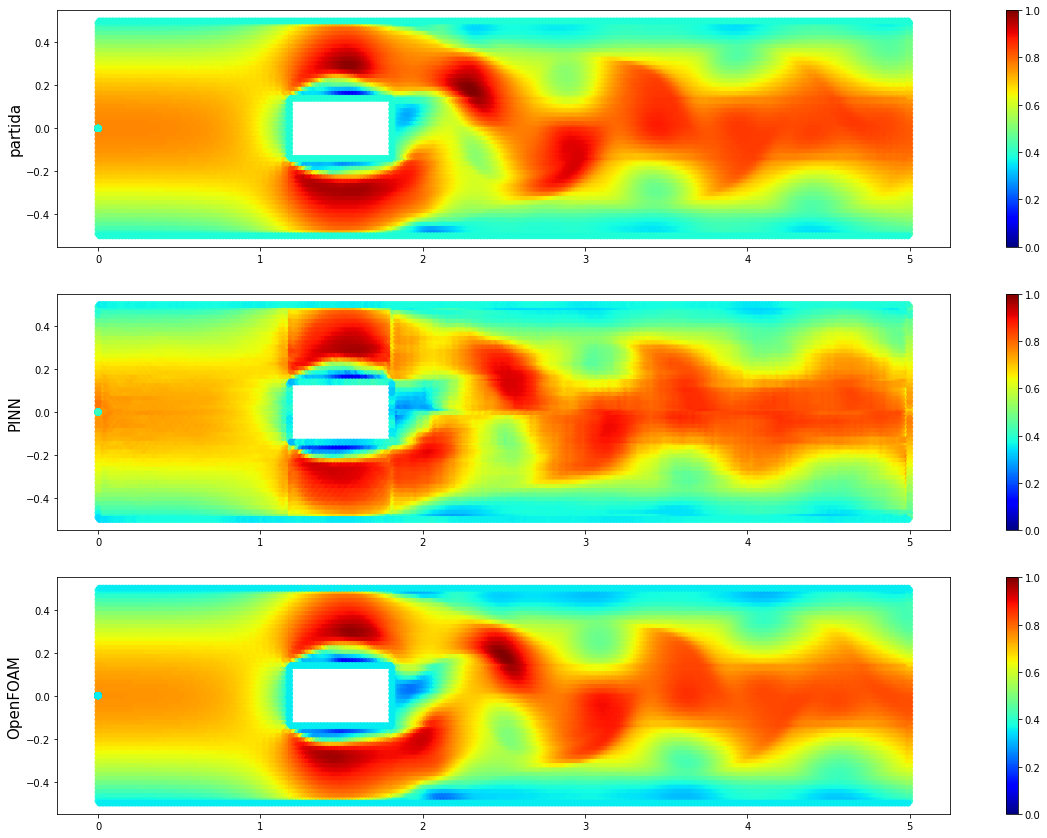

In [ ]:
i=40
sim= 1
variable = 0
x = x_test[i,:,3]
y = x_test[i,:,4]
z_partida = x_test[i,:,variable]
z = y_test[i,:,variable]
z_model = model([x_test[i,:,0:3].reshape((1,) + (13104,3)), x_test[i,:,3:5].reshape((1,) + (13104,2))])[0,:,variable]

print(np.max( y_train[sim,:,variable]) )
print(z.shape)


fig = plt.figure(figsize=(20,20))

plt.subplot(412)
plt.ylabel('PINN', fontsize=15)
plt.scatter(x, y, c=z_model, cmap='jet', vmax = 1, vmin=0)
plt.colorbar()


plt.subplot(413)
plt.ylabel('OpenFOAM', fontsize=15)
plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
plt.colorbar()

plt.subplot(411)
plt.ylabel('partida', fontsize=15)
plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
plt.colorbar()

plt.show()

In [ ]:
path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)



for i in range(49):

  x = x_test[i,:,3]
  y = x_test[i,:,4]
  z_model = model([x_test[i,:,0:3].reshape((1,) + (13104,3)), x_test[i,:,3:5].reshape((1,) + (13104,2))])

  fig = plt.figure(figsize=(20,20))

  plt.subplot(412)
  plt.ylabel('p - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,2], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:,2]
  z = y_test[i,:,2]

  plt.subplot(413)
  plt.ylabel('p - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('p - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/p' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('ux - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,0], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:,0]
  z = y_test[i,:,0]


  plt.subplot(413)
  plt.ylabel('ux -CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('ux - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/ux' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('uy - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,1], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:,1]
  z = y_test[i,:,1]

  plt.subplot(413)
  plt.ylabel('uy - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('uy - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/uy' + str(i) + '.png')
  plt.close()


In [ ]:
filenamesp = []
filenamesux = []
filenamesuy = []
for i in range(49):
  filenamesp.append("/content/plots/p" + str(i) +".png") #hardcoded to get the frames in order
  filenamesux.append("/content/plots/ux" + str(i) +".png") #hardcoded to get the frames in order
  filenamesuy.append("/content/plots/uy" + str(i) +".png") #hardcoded to get the frames in order

In [ ]:
import imageio

with imageio.get_writer('/content/p_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesp:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/content/ux_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesux:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/content/uy_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesuy:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.interpolate import griddata
import numpy as np

i=29
x = x_test[i,:,3]
y = x_test[i,:,4]
z = y_test[i,:,0]

idx = np.lexsort((y, x)).reshape(50, 250)

#plt.imshow(x[idx], y[idx], z[idx], cmap = 'jet',extent=[x.min(), x.max(), -3, 3] )

plt.imshow( z[idx], interpolation='bilinear', cmap='jet',
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=1, vmin=0)


ValueError: ignored

#Try tfrecords

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [ ]:
x_train0 = x_train[0].flatten()
print(x_train0)
example = tf.train.Example(features=tf.train.Features(feature={"x_train": _float_feature(x_train0)}))
print(example)

[0. 0. 0. ... 0. 0. 0.]
features {
  feature {
    key: "x_train"
    value {
      float_list {
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.009999999776482582
        value: 0.011250000447034836
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.029999999329447746
        value: 0.011250000447034836
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.05000000074505806
        value: 0.011250000447034836
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.07000000029802322
        value: 0.011250000447034836
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.09000000357627869
        value: 0.011250000447034836
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.0
        value: 0.10999999940395355
        value: 0.011250000447034836
        value: 0.0
        value: 0.0


In [ ]:
def parse_single_image(image, label):
  
  #define the dictionary -- the structure -- of our single example
  data = {
        'height' : _int64_feature(image.shape[0]),
        'depth_x' : _int64_feature(image.shape[1]),
        'depth_y' : _int64_feature(label.shape[1]),
        'raw_image' : _bytes_feature(tf.io.serialize_tensor(image)),
        'label' : _bytes_feature(tf.io.serialize_tensor(label)),
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

In [ ]:
import tqdm
def write_images_to_tfr_long(images, labels, filename:str="large_images", max_files:int=10, out_dir:str="/content/"):

  #determine the number of shards (single TFRecord files) we need:
  splits = (len(images)//max_files) + 1 #determine how many tfr shards are needed
  if len(images)%max_files == 0:
    splits-=1
  print(f"\nUsing {splits} shard(s) for {len(images)} files, with up to {max_files} samples per shard")

  file_count = 0
   
  for i in tqdm.tqdm(range(splits)):
    current_shard_name = "{}{}_{}{}.tfrecords".format(out_dir, i+1, splits, filename)
    writer = tf.io.TFRecordWriter(current_shard_name)

    current_shard_count = 0
    while current_shard_count < max_files: #as long as our shard is not full
      #get the index of the file that we want to parse now
      index = i*max_files+current_shard_count
      if index == len(images): #when we have consumed the whole data, preempt generation
        break

      current_image = images[index].astype('float64')
      current_label = labels[index].astype('float64')

      #create the required Example representation
      out = parse_single_image(image=current_image, label=current_label)
    
      writer.write(out.SerializeToString())
      current_shard_count+=1
      file_count += 1

    writer.close()
  print(f"\nWrote {file_count} elements to TFRecord")
  return file_count

In [ ]:
write_images_to_tfr_long(x_train, y_train, max_files=100)

  0%|          | 0/20 [00:00<?, ?it/s]


Using 20 shard(s) for 2000 files, with up to 100 samples per shard


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Wrote 2000 elements to TFRecord


2000

In [ ]:
def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'label' : tf.io.FixedLenFeature([], tf.string),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth_x':tf.io.FixedLenFeature([], tf.int64),
      'depth_y':tf.io.FixedLenFeature([], tf.int64)
    }

  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  depth_x = content['depth_x']
  depth_y = content['depth_y']
  label = content['label']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  feature = tf.io.parse_tensor(raw_image, out_type=tf.float64)


  label = tf.io.parse_tensor(label, out_type=tf.float64)


  return (feature, label)

In [ ]:
def get_dataset_large(tfr_dir:str="/content/", pattern:str="*large_images.tfrecords"):
    files = glob.glob(tfr_dir+pattern, recursive=False)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element)
    
    return dataset

In [ ]:
import glob

def get_dataset():
  dataset = get_dataset_large()
  dataset = dataset.shuffle(buffer_size=1028)
  #dataset = dataset.prefetch()
  dataset = dataset.batch(32)
  return dataset

train_dataset = get_dataset()

In [ ]:
def conv_model():
  input_layer = tf.keras.Input ((52 * 252, 6))
  x = tf.keras.layers.Masking(mask_value=0.)(input_layer)
  x = tf.keras.layers.Dense(10, activation='tanh')(x) 
  x = tf.keras.layers.Dropout(.1)(x)
  x = tf.keras.layers.Dense(20, activation='tanh')(x) 
  x = tf.keras.layers.Dropout(.1)(x)
  #x = tf.keras.layers.Dense(30, activation='tanh')(x)
  #x = tf.keras.layers.Dropout(.1)(x) 
  x = tf.keras.layers.Dense(30, activation='tanh')(x)
  x = tf.keras.layers.Dropout(.1)(x) 
  #x = tf.keras.layers.Dense(20, activation='tanh')(x)
  #x = tf.keras.layers.Dropout(.1)(x) 
  x = tf.keras.layers.Dense(20, activation='tanh')(x)
  x = tf.keras.layers.Dropout(.1)(x) 
  x = tf.keras.layers.Dense(10, activation='tanh')(x)
  x = tf.keras.layers.Dropout(.1)(x) 
  output_layer =  tf.keras.layers.Dense(3)(x)
  
  model = tf.keras.Model(inputs=[input_layer], outputs = [output_layer])

  print(model.summary())
  return model

model = conv_model()

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(get_dataset(), epochs=10, validation_data=(x_test,y_test))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 13104, 6)]        0         
_________________________________________________________________
masking_6 (Masking)          (None, 13104, 6)          0         
_________________________________________________________________
dense_36 (Dense)             (None, 13104, 10)         70        
_________________________________________________________________
dropout_30 (Dropout)         (None, 13104, 10)         0         
_________________________________________________________________
dense_37 (Dense)             (None, 13104, 20)         220       
_________________________________________________________________
dropout_31 (Dropout)         (None, 13104, 20)         0         
_________________________________________________________________
dense_38 (Dense)             (None, 13104, 30)         630 

ValueError: ignored

In [ ]:
train_dataset = dataset_large.batch(32)

In [ ]:
 for (x_batch_train, y_batch_train) in enumerate (train_dataset):
   print(y_batch_train.shape)

(32,)
(32,)
(32,)
(32,)
(32,)
(32,)
(32,)


KeyboardInterrupt: ignored

In [ ]:
# Convert values to compatible tf.Example types.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
# Create the features dictionary.
def image_example(image, label, dimension, depth_x, depth_y):
    feature = {
        'dimension': _int64_feature(dimension),
        'depth_x': _int64_feature(depth_x),
        'depth_y': _int64_feature(depth_y),
        'label': _bytes_feature(tf.io.serialize_tensor(image)),
        'image_raw': _bytes_feature(tf.io.serialize_tensor(label))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
record_file = 'mnistTrain.tfrecords'
n_samples = 2000
dimension = 13104
depth_x = 6
depth_y = 3
with tf.io.TFRecordWriter(record_file) as writer:
   for i in range(n_samples):
      image = x_train[i].astype('float64')
      label = y_train[i].astype('float64')
      tf_example = image_example(image, label, dimension, depth_x, depth_y)
      writer.write(tf_example.SerializeToString())

In [ ]:
# Create the dataset object from tfrecord file(s)
dataset = tf.data.TFRecordDataset(record_file, buffer_size=100)

train_dataset = dataset.batch(32)


In [ ]:
for record in dataset:
    parsed_record = parse_record(record)
    decoded_record = decode_record(parsed_record)
    image, label = decoded_record
    print(image.shape, label.shape)
    break

(13104, 3) (13104, 6)


In [ ]:
# Decoding function
def parse_record(record):
    name_to_features = {
        'dimension': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string),
        'depth_x': tf.io.FixedLenFeature([], tf.int64),
        'depth_y': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

In [ ]:

def decode_record(record):

    image = record['image_raw']
    label = record['label']
    image = tf.io.parse_tensor(image, out_type=tf.float64)
    label = tf.io.parse_tensor(label, out_type=tf.float64)
    
    dimension = record['dimension']
    depth_x = record['depth_x']
    depth_y = record['depth_y']

    return (image, label)

234

In [ ]:
import tensorflow as tf
import numpy as np

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

# Create example data
array_blueprint = np.arange(4, dtype='float64').reshape(2,2)
arrays = [x_train[0,0:100,:].astype('float64'), y_train[0,0:100,:].astype('float64')]

#----------------------------------------------------------------------------------
# Write TFrecord file
file_path = 'data.tfrecords'
with tf.io.TFRecordWriter(file_path) as writer:

  feature = {
    'image': _bytes_feature(serialize_array(arrays[0])),
    'label': _bytes_feature(serialize_array(arrays[1]))
  }

  example_message = tf.train.Example(features=tf.train.Features(feature=feature))
  writer.write(example_message.SerializeToString())

In [ ]:
# Read TFRecord file
def _parse_tfr_element(element):
  parse_dic = {
      'label' : tf.io.FixedLenFeature([], tf.string),
      'image' : tf.io.FixedLenFeature([], tf.string)
    }
  example_message = tf.io.parse_single_example(element, parse_dic)

  image = example_message['image'] # get byte string
  label = example_message['label'] # get byte string

  feature = tf.io.parse_tensor(image, out_type=tf.float64) # restore 2D array from byte string
  image = tf.io.parse_tensor(label, out_type=tf.float64) # restore 2D array from byte string
  return (image,label)


tfr_dataset = tf.data.TFRecordDataset('data.tfrecords') 
for serialized_instance in tfr_dataset:
  print(serialized_instance) # print serialized example messages

dataset = tfr_dataset.map(_parse_tfr_element)
for instance in dataset:
  print()
  print(instance) # print parsed example messages with restored arrays

In [ ]:
#-------------------------------------------------------------------------------------------------------------------

# RUN ALL

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import numpy as np
import math
from numba import njit


def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:117, 0:50, ...]
    y = hdf5_file["sim_data"][:117, 1:51, ...]
    sim_no = hdf5_file["sim_no"][:117, 0]
    hdf5_file.close()

    times = 50

    @njit
    def index(array, item):
      for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.
  
    for i in range(y.shape[0]):
      indice = index(y[i,0,:,0] , -100.0 )[0]
      if np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]) != 0:
        y[i,:,:indice,0] = (y[i,:,:indice,0] - np.ones((y[i,:,:indice,0].shape))*np.min(y[i,:,:indice,0]))/(np.max(y[i,:,:indice,0])-np.min(y[i,:,:indice,0]))
        y[i,:,:indice,1] = (y[i,:,:indice,1] - np.ones((y[i,:,:indice,1].shape))*np.min(y[i,:,:indice,1]))/(np.max(y[i,:,:indice,1])-np.min(y[i,:,:indice,1]))
        y[i,:,:indice,2] = (y[i,:,:indice,2] - np.ones((y[i,:,:indice,2].shape))*np.min(y[i,:,:indice,2]))/(np.max(y[i,:,:indice,2])-np.min(y[i,:,:indice,2]))

    for i in range(x.shape[0]):
      indice = index(x[i,0,:,0] , -100.0 )[0]
      if np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]) != 0:
        x[i,:,:indice,0] = (x[i,:,:indice,0] - np.ones((x[i,:,:indice,0].shape))*np.min(x[i,:,:indice,0]))/(np.max(x[i,:,:indice,0])-np.min(x[i,:,:indice,0]))
        x[i,:,:indice,1] = (x[i,:,:indice,1] - np.ones((x[i,:,:indice,1].shape))*np.min(x[i,:,:indice,1]))/(np.max(x[i,:,:indice,1])-np.min(x[i,:,:indice,1]))
        x[i,:,:indice,2] = (x[i,:,:indice,2] - np.ones((x[i,:,:indice,2].shape))*np.min(x[i,:,:indice,2]))/(np.max(x[i,:,:indice,2])-np.min(x[i,:,:indice,2]))



    total_sim = x.shape[0]

    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]


    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test

hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.9, print_shape=True)


assert not np.any(np.isnan(x_train))
assert not np.any(np.isnan(y_train))

assert not np.any(np.isnan(x_test))
assert not np.any(np.isnan(y_test))

@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.



def my_mse_loss():
  def equation_loss(y_true, y_pred):

    loss = 0

    for i in range(y_true.shape[0]):
      y = np.array(y_true[i,0,:,0])
      indice = index(y , -100.0 )[0]

      ux = y_true[i,:,:indice,0]
      uy = y_true[i,:,:indice,1]
      p = y_true[i,:,:indice,2]

      
      ux_pred = y_pred[i,:,:indice,0]
      uy_pred = y_pred[i,:,:indice,1]
      p_pred = y_pred[i,:,:indice,2]

      loss += tf.reduce_mean(tf.square(ux - ux_pred) + \
                  tf.square(uy - uy_pred) + \
                  tf.square(p - p_pred))
      
    loss /= y_true.shape[0]

    return loss

  return equation_loss

import tensorflow as tf

def conv_bn(x, filters):
    x = tf.keras.layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
    return tf.keras.layers.Activation("relu")(x)


def dense_bn(x, filters, activation = "relu"):
    x = tf.keras.layers.Dense(filters)(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
    return tf.keras.layers.Activation(activation)(x)
    
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = tf.keras.layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = tf.keras.layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return tf.keras.layers.Dot(axes=(2, 1))([inputs, feat_T])

def conv_model_times(print_model = True, times= 50, NUM_POINTS=4000):

#info of p, u,v:
  inputs = tf.keras.Input(shape=( None , NUM_POINTS, 3))
  

  layer = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(inputs)

  c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same'))(layer)  # (None, 50, 150, 32)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c1)  # (None, 25, 75, 32)

  c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, 2, activation='relu', padding='same'))(x_var)  # (None, 25, 75, 64)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c2)  # (None, 13, 38, 64)

  c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same'))(x_var)  # (None, 13, 38, 128)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c3)  # (None, 7, 19, 128)

  x_var = tf.keras.layers.ConvLSTM1D(filters=256, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(128, 2, strides=2, padding='same'))(x_var)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=(1, 0))(x)
  x_var = tf.keras.layers.Add()([x_var, c3])

  x_var = tf.keras.layers.ConvLSTM1D(filters=128, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(64, 2, strides=2, padding='same'))(x_var)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=((1, 0)))(x)
  x_var = tf.keras.layers.Add()([x_var, c2])



  x_var = tf.keras.layers.ConvLSTM1D(filters=64, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(32, 3 , strides=2 , padding='same'))(x_var)
  x_var = tf.keras.layers.Add()([x_var, c1])

  x_var = tf.keras.layers.Conv1D(filters=3, kernel_size= 3 , activation='linear', padding='same', data_format='channels_last')(x_var)

  layer_var =  tf.keras.layers.Dense(3, activation='sigmoid')(x_var)


#spatial info:
  inputs_coordinates = tf.keras.Input(shape=( NUM_POINTS, 2))

  x = tnet(inputs_coordinates, 2)
  x = conv_bn(x, 32)
  x = conv_bn(x, 32)
  x = tnet(x, 32)
  x1 = conv_bn(x, 32)
  x = conv_bn(x1, 64)
  x = conv_bn(x, 512)
  global_feature = tf.keras.layers.GlobalMaxPooling1D()(x)
  global_feature_layer = tf.reshape(global_feature,(-1,  1, 512))
  global_feature_layer = tf.tile(global_feature_layer,(1 , NUM_POINTS, 1))
  x = tf.keras.layers.concatenate([x1, global_feature_layer ],axis=2)

  x = tf.reshape(x,(-1,  1, NUM_POINTS, 512+32))
  x = tf.tile(x,(1, times , 1, 1))
  x = tf.keras.layers.concatenate([x, layer_var], axis = 3)


  x = conv_bn(x, 256)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_bn(x, 128)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_bn(x, 64)
  #x = layers.Dropout(0.3)(x)
  x = dense_bn(x, 128)
  outputs = dense_bn(x, 3, activation="sigmoid")

  
  model = tf.keras.Model(inputs=[inputs, inputs_coordinates], outputs = [outputs])

  if print_model == True:
    model.summary()
    tf.keras.utils.plot_model(model)

  return model

# Convert values to compatible tf.Example types.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
def parse_single_image(image, label):
  
  #define the dictionary -- the structure -- of our single example
  data = {
        'height' : _int64_feature(image.shape[0]),
        'depth_x' : _int64_feature(image.shape[1]),
        'depth_y' : _int64_feature(label.shape[1]),
        'raw_image' : _bytes_feature(tf.io.serialize_tensor(image)),
        'label' : _bytes_feature(tf.io.serialize_tensor(label)),
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

def write_images_to_tfr_short(images, labels, filename:str="images"):
  filename= filename+".tfrecords"
  writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
  count = 0

  for index in range(len(images)):

    #get the data we want to write
    current_image = images[index].astype('float64')
    current_label = labels[index].astype('float64')

    out = parse_single_image(image=current_image, label=current_label)
    writer.write(out.SerializeToString())
    count += 1

  writer.close()
  print(f"Wrote {count} elements to TFRecord")
  return count

count = write_images_to_tfr_short(x_train[:,:,:,0:5], y_train[:,:,:,0:3], filename="small_images_train")
count = write_images_to_tfr_short(x_test[:,:,:,0:5], y_test[:,:,:,0:3], filename="small_images_test")


def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'label' : tf.io.FixedLenFeature([], tf.string),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth_x':tf.io.FixedLenFeature([], tf.int64),
      'depth_y':tf.io.FixedLenFeature([], tf.int64)
    }

  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  depth_x = content['depth_x']
  depth_y = content['depth_y']
  label = content['label']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  
  feature= tf.io.parse_tensor(raw_image, out_type=tf.float64)
  feature_1 = feature[...,0:3]
  feature_2 = feature[...,3:5]
  label = tf.io.parse_tensor(label, out_type=tf.float64)


  return ( {"feature_1": feature_1, "feature_2": feature_2} , label)

def load_dataset(filename, batch_size, buffer_size):
  #create the dataset
  dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
  dataset = dataset.map(
      parse_tfr_element
  )

  dataset = dataset.shuffle(buffer_size=buffer_size )
  #epoch = tf.data.Dataset.range(epoch_num)
  dataset = dataset.batch(batch_size)

  return dataset  
  #return tf.compat.v1.data.make_one_shot_iterator(dataset)

train_path = "/content/small_images_train.tfrecords"
test_path = "/content/small_images_test.tfrecords"

batch_size = 1

train_dataset = load_dataset(filename = train_path, batch_size= batch_size, buffer_size=1024)
test_dataset = load_dataset(filename = test_path, batch_size= batch_size, buffer_size=1024)

#train_len = x_train.shape[0]
x_train, x_test, y_train,  y_test = None, None, None, None


lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
loss_object = my_mse_loss()
#tf.keras.losses.MeanSquaredError()
#loss_object = eq_loss()

#train_acc_metric = tf.keras.metrics.MeanSquaredError()
#val_acc_metric = tf.keras.metrics.MeanSquaredError()

#coding the training
#@tf.function
def apply_gradient(optimizer, model , x1, x2, y):
  with tf.GradientTape() as tape:
    logits = model([x1,x2])  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(y_true = y , y_pred = logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return logits, loss_value

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train, y_batch_train) in enumerate (train_dataset):

    x_batch_train_1 = tf.cast(x_batch_train['feature_1'], dtype='float32')
    x_batch_train_2 = tf.cast(x_batch_train['feature_2'][:,0,:,:], dtype='float32')
    y_batch_train = tf.cast(y_batch_train, dtype='float32')
    
    logits , loss_value = apply_gradient(optimizer , model , x_batch_train_1, x_batch_train_2 , y_batch_train)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    progbar.update(step+1)

  return losses

#@tf.function
def perform_validation():
  losses = []

  for x_val, y_val in test_dataset:
    x_val_1 = tf.cast(x_val['feature_1'], dtype='float32')
    x_val_2 = tf.cast(x_val['feature_2'][:,0,:,:], dtype='float32')
    y_val = tf.cast(y_val, dtype='float32')

    val_logits = model([x_val_1 , x_val_2])
    #val_loss = loss_object(y_true= y_val , y_pred = val_logits, x=x_val)
    val_loss = loss_object(y_true= y_val , y_pred = val_logits)
    losses.append(val_loss)
    #val_acc_metric(y_val,val_logits)
  return losses


from tqdm import tqdm 
import math

model = conv_model_times()
epochs = 20
epochs_val_losses, epochs_train_losses = [], []

train_len = 105

for epoch in range(epochs):
  
  progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()
  #train_acc = train_acc_metric.result()

  losses_val  = perform_validation()
  #val_acc = val_acc_metric.result()

  losses_train_mean = tf.reduce_mean(losses_train[0:len(losses_train)-1])
  losses_val_mean = tf.reduce_mean(losses_val[0:len(losses_val)-1])
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f , Validation Loss: %.4f , Train Accuracy: %.4f , Validation Accuracy: %.4f \n' % (epoch,float(losses_train_mean), float(losses_val_mean), float(losses_train_mean), float(losses_val_mean)))
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()

hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.9, print_shape=True)

loss_object_eval = tf.keras.losses.MeanSquaredError()

model.compile(optimizer,loss_object_eval)
score = model.evaluate(x=[x_test[:5,:,0:3],x_test[:5,:,3:5]], y=y_test[:5,:,0:3], verbose=1)

print('Average Mean Squared Error:', score)


model.save_weights("weights_model_points.h5")

total_sim: 117
x_train.shape: (105, 50, 4000, 5)
y_train.shape: (105, 50, 4000, 5)
x_test.shape: (12, 50, 4000, 5)
y_test.shape: (12, 50, 4000, 5)

Wrote 105 elements to TFRecord
Wrote 12 elements to TFRecord
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 4000, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_100 (Conv1D)             (None, 4000, 32)     96          input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 4000, 32)     128         conv1d_100[0][0]                 
_________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.9, print_shape=True)

loss_object_eval = tf.keras.losses.MeanSquaredError()

model.compile(optimizer,loss_object_eval)
score = model.evaluate(x=[x_test[:5,:,:,0:3],x_test[:5,0,:,3:5]], y=y_test[:5,:,:,0:3], verbose=1)

print('Average Mean Squared Error:', score)


model.save_weights("weights_model_points.h5")

total_sim: 117
x_train.shape: (105, 50, 4000, 5)
y_train.shape: (105, 50, 4000, 5)
x_test.shape: (12, 50, 4000, 5)
y_test.shape: (12, 50, 4000, 5)

1/1 [==============================] - 6s 6s/step - loss: 1618.1909
Average Mean Squared Error: 1618.19091796875


In [ ]:
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.



def my_mse_loss():
  def equation_loss(y_true, y_pred):

    loss = 0

    for i in range(y_true.shape[0]):
      y = np.array(y_true[i,0,:,0])
      indice = index(y , -100.0 )[0]

      ux = y_true[i,:,:indice,0]
      uy = y_true[i,:,:indice,1]
      p = y_true[i,:,:indice,2]

      
      ux_pred = y_pred[i,:,:indice,0]
      uy_pred = y_pred[i,:,:indice,1]
      p_pred = y_pred[i,:,:indice,2]

      loss += tf.reduce_mean(tf.square(ux - ux_pred) + \
                  tf.square(uy - uy_pred) + \
                  tf.square(p - p_pred))
      
    loss /= y_true.shape[0]

    return loss

  return equation_loss

import tensorflow as tf

def conv_bn(x, filters):
    x = tf.keras.layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
    return tf.keras.layers.Activation("relu")(x)


def dense_bn(x, filters, activation = "relu"):
    x = tf.keras.layers.Dense(filters)(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.0)(x)
    return tf.keras.layers.Activation(activation)(x)
    
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = tf.keras.layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = tf.keras.layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return tf.keras.layers.Dot(axes=(2, 1))([inputs, feat_T])

def conv_model_times(print_model = True, times= 50, NUM_POINTS=4000):

#info of p, u,v:
  inputs = tf.keras.Input(shape=( None , NUM_POINTS, 3))
  

  layer = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(inputs)

  c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same'))(layer)  # (None, 50, 150, 32)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c1)  # (None, 25, 75, 32)

  c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, 2, activation='relu', padding='same'))(x_var)  # (None, 25, 75, 64)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c2)  # (None, 13, 38, 64)

  c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, 2, activation='relu', padding='same'))(x_var)  # (None, 13, 38, 128)
  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same'))(c3)  # (None, 7, 19, 128)

  x_var = tf.keras.layers.ConvLSTM1D(filters=256, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(128, 2, strides=2, padding='same'))(x_var)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=(1, 0))(x)
  x_var = tf.keras.layers.Add()([x_var, c3])

  x_var = tf.keras.layers.ConvLSTM1D(filters=128, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(64, 2, strides=2, padding='same'))(x_var)
  #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping1D(cropping=((1, 0)))(x)
  x_var = tf.keras.layers.Add()([x_var, c2])



  x_var = tf.keras.layers.ConvLSTM1D(filters=64, kernel_size=3, activation='relu',
                  recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x_var)

  x_var = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1DTranspose(32, 3 , strides=2 , padding='same'))(x_var)
  x_var = tf.keras.layers.Add()([x_var, c1])

  x_var = tf.keras.layers.Conv1D(filters=3, kernel_size= 3 , activation='linear', padding='same', data_format='channels_last')(x_var)

  layer_var =  tf.keras.layers.Dense(3, activation='sigmoid')(x_var)


#spatial info:
  inputs_coordinates = tf.keras.Input(shape=( NUM_POINTS, 2))

  x = tnet(inputs_coordinates, 2)
  x = conv_bn(x, 32)
  x = conv_bn(x, 32)
  x = tnet(x, 32)
  x1 = conv_bn(x, 32)
  x = conv_bn(x1, 64)
  x = conv_bn(x, 512)
  global_feature = tf.keras.layers.GlobalMaxPooling1D()(x)
  global_feature_layer = tf.reshape(global_feature,(-1,  1, 512))
  global_feature_layer = tf.tile(global_feature_layer,(1 , NUM_POINTS, 1))
  x = tf.keras.layers.concatenate([x1, global_feature_layer ],axis=2)

  x = tf.reshape(x,(-1,  1, NUM_POINTS, 512+32))
  x = tf.tile(x,(1, times , 1, 1))
  x = tf.keras.layers.concatenate([x, layer_var], axis = 3)


  x = conv_bn(x, 256)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_bn(x, 128)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = conv_bn(x, 64)
  #x = layers.Dropout(0.3)(x)
  x = dense_bn(x, 128)
  outputs = dense_bn(x, 3, activation="sigmoid")

  
  model = tf.keras.Model(inputs=[inputs, inputs_coordinates], outputs = [outputs])

  if print_model == True:
    model.summary()
    tf.keras.utils.plot_model(model)

  return model

In [ ]:
# Convert values to compatible tf.Example types.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
def parse_single_image(image, label):
  
  #define the dictionary -- the structure -- of our single example
  data = {
        'height' : _int64_feature(image.shape[0]),
        'depth_x' : _int64_feature(image.shape[1]),
        'depth_y' : _int64_feature(label.shape[1]),
        'raw_image' : _bytes_feature(tf.io.serialize_tensor(image)),
        'label' : _bytes_feature(tf.io.serialize_tensor(label)),
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

def write_images_to_tfr_short(images, labels, filename:str="images"):
  filename= filename+".tfrecords"
  writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
  count = 0

  for index in range(len(images)):

    #get the data we want to write
    current_image = images[index].astype('float64')
    current_label = labels[index].astype('float64')

    out = parse_single_image(image=current_image, label=current_label)
    writer.write(out.SerializeToString())
    count += 1

  writer.close()
  print(f"Wrote {count} elements to TFRecord")
  return count

count = write_images_to_tfr_short(x_train[:,:,:,0:5], y_train[:,:,:,0:3], filename="small_images_train")
count = write_images_to_tfr_short(x_test[:,:,:,0:5], y_test[:,:,:,0:3], filename="small_images_test")


Wrote 105 elements to TFRecord
Wrote 12 elements to TFRecord


In [ ]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
loss_object = my_mse_loss()
#tf.keras.losses.MeanSquaredError()
#loss_object = eq_loss()

#train_acc_metric = tf.keras.metrics.MeanSquaredError()
#val_acc_metric = tf.keras.metrics.MeanSquaredError()

#coding the training
#@tf.function
def apply_gradient(optimizer, model , x1, x2, y):
  with tf.GradientTape() as tape:
    logits = model([x1,x2])  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(y_true = y , y_pred = logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return logits, loss_value

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train, y_batch_train) in enumerate (train_dataset):

    x_batch_train_1 = tf.cast(x_batch_train['feature_1'], dtype='float32')
    x_batch_train_2 = tf.cast(x_batch_train['feature_2'][:,0,:,:], dtype='float32')
    y_batch_train = tf.cast(y_batch_train, dtype='float32')
    
    logits , loss_value = apply_gradient(optimizer , model , x_batch_train_1, x_batch_train_2 , y_batch_train)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    progbar.update(step+1)

  return losses

#@tf.function
def perform_validation():
  losses = []

  for x_val, y_val in test_dataset:
    x_val_1 = tf.cast(x_val['feature_1'], dtype='float32')
    x_val_2 = tf.cast(x_val['feature_2'][:,0,:,:], dtype='float32')
    y_val = tf.cast(y_val, dtype='float32')

    val_logits = model([x_val_1 , x_val_2])
    #val_loss = loss_object(y_true= y_val , y_pred = val_logits, x=x_val)
    val_loss = loss_object(y_true= y_val , y_pred = val_logits)
    losses.append(val_loss)
    #val_acc_metric(y_val,val_logits)
  return losses


In [ ]:
#continue training


def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'label' : tf.io.FixedLenFeature([], tf.string),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'depth_x':tf.io.FixedLenFeature([], tf.int64),
      'depth_y':tf.io.FixedLenFeature([], tf.int64)
    }

  content = tf.io.parse_single_example(element, data)
  
  height = content['height']
  depth_x = content['depth_x']
  depth_y = content['depth_y']
  label = content['label']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  
  feature= tf.io.parse_tensor(raw_image, out_type=tf.float64)
  feature_1 = feature[...,0:3]
  feature_2 = feature[...,3:5]
  label = tf.io.parse_tensor(label, out_type=tf.float64)


  return ( {"feature_1": feature_1, "feature_2": feature_2} , label)

def load_dataset(filename, batch_size, buffer_size):
  #create the dataset
  dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
  dataset = dataset.map(
      parse_tfr_element
  )

  dataset = dataset.shuffle(buffer_size=buffer_size )
  #epoch = tf.data.Dataset.range(epoch_num)
  dataset = dataset.batch(batch_size)

  return dataset  
  #return tf.compat.v1.data.make_one_shot_iterator(dataset)

train_path = "/content/small_images_train.tfrecords"
test_path = "/content/small_images_test.tfrecords"

batch_size = 1

train_dataset = load_dataset(filename = train_path, batch_size= batch_size, buffer_size=1024)
test_dataset = load_dataset(filename = test_path, batch_size= batch_size, buffer_size=1024)

#train_len = x_train.shape[0]
x_train, x_test, y_train,  y_test = None, None, None, None


model = conv_model_times()

model.load_weights("weights_model_points.h5")

from tqdm import tqdm 
import math

#model = conv_model_times()
epochs = 20
epochs_val_losses, epochs_train_losses = [], []

train_len = 105

for epoch in range(epochs):
  
  progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()
  #train_acc = train_acc_metric.result()

  losses_val  = perform_validation()
  #val_acc = val_acc_metric.result()

  losses_train_mean = tf.reduce_mean(losses_train[0:len(losses_train)-1])
  losses_val_mean = tf.reduce_mean(losses_val[0:len(losses_val)-1])
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f , Validation Loss: %.4f , Train Accuracy: %.4f , Validation Accuracy: %.4f \n' % (epoch,float(losses_train_mean), float(losses_val_mean), float(losses_train_mean), float(losses_val_mean)))
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()

hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.9, print_shape=True)

loss_object_eval = tf.keras.losses.MeanSquaredError()

model.compile(optimizer,loss_object_eval)
score = model.evaluate(x=[x_test[:5,:,0:3],x_test[:5,:,3:5]], y=y_test[:5,:,0:3], verbose=1)

print('Average Mean Squared Error:', score)


model.save_weights("weights_model_points.h5")

# refine model

In [11]:
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx

indice = index(np.array(x_test[0,0,:,0]) , -100.0 )[0]

prev = model([x_test[0:1,:,:,0:3],x_test[0:1,0,:,3:5],x_test[0:1,0,:,5:6]] )

indice = 4000
#prev_without_padd= prev[:,:,:indice,:]

#prev_new = np.array(prev_without_padd)
prev_new = np.array(prev)
x_data = {"feature_1": prev_new.reshape(1,1,50, indice,3), "feature_2":  x_test[0:1,0:1,:indice,3:5], "feature_3": x_train[0:1,0:1,:indice,5:6] }
#x_data = np.concatenate( (prev_new.reshape(1,50, indice,3), x_test[0,0:50,:indice,3:5].reshape(1,50, indice,2),x_train[0,0:50,:indice,5:6].reshape(1,50, indice,1)) , axis=3) 
data = tf.data.Dataset.from_tensor_slices(x_data)

#denormalizing:

max_0 = max_min_list[0]
max_1 = max_min_list[1]
max_2 = max_min_list[2]

min_0 = max_min_list[3]
min_1 = max_min_list[4]
min_2 = max_min_list[5]

prev_new[:,:,:,0] = (max_0 - min_0) * prev_new[:,:,:,0] + np.ones((prev_new[:,:,:,0].shape))*min_0
prev_new[:,:,:,1] = (max_1 - min_1) * prev_new[:,:,:,1] + np.ones((prev_new[:,:,:,1].shape))*min_1
prev_new[:,:,:,2] = (max_2 - min_2) * prev_new[:,:,:,2] + np.ones((prev_new[:,:,:,2].shape))*min_2



In [12]:
x__  = x_test[0:1,0,:,3:4]
print(x__.shape)
tf.tile(x__.reshape((1,1,4000)), (1,50,1))

(1, 4000, 1)


<tf.Tensor: shape=(1, 50, 4000), dtype=float64, numpy=
array([[[ 1.00531997e-02,  9.04787034e-02,  1.70903996e-01, ...,
         -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
        [ 1.00531997e-02,  9.04787034e-02,  1.70903996e-01, ...,
         -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
        [ 1.00531997e-02,  9.04787034e-02,  1.70903996e-01, ...,
         -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
        ...,
        [ 1.00531997e-02,  9.04787034e-02,  1.70903996e-01, ...,
         -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
        [ 1.00531997e-02,  9.04787034e-02,  1.70903996e-01, ...,
         -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
        [ 1.00531997e-02,  9.04787034e-02,  1.70903996e-01, ...,
         -1.00000000e+02, -1.00000000e+02, -1.00000000e+02]]])>

In [11]:
from numpy import random
@tf.function
def f_model_cont(x1,x2,x3):
  
  dtype = "float32"



  ux = tf.convert_to_tensor(x1[:,:,:,0:1], dtype=dtype)
  uy = tf.convert_to_tensor(x1[:,:,:,1:2], dtype=dtype)
  p = tf.convert_to_tensor(x1[:,:,:,2:3], dtype=dtype)
  
  x = tf.convert_to_tensor(x2[:,:,0:1], dtype=dtype)
  y = tf.convert_to_tensor(x2[:,:,1:2], dtype=dtype)
  t = tf.convert_to_tensor(x3[:,:,0:1], dtype=dtype)



  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    X1 = tf.stack([ux , uy , p], axis=3)
    X2 = tf.stack([x, y], axis=2)

    y_pred = model([X1,X2,x3])
    print(y_pred.shape)

    ux = y_pred[:,:,:,0]
    uy = y_pred[:,:,:,1]
    p = y_pred[:,:,:,2]

    ux = (max_0 - min_0) * ux + np.ones((ux.shape))*min_0
    uy = (max_1 - min_1) * uy + np.ones((uy.shape))*min_1
    p = (max_2 - min_2) * p + np.ones((p.shape))*min_2

    x = tf.tile(tf.reshape(x , (1,1,4000)), (1,50,1))
    y = tf.tile(tf.reshape(y , (1,1,4000)), (1,50,1))
    t = tf.tile(tf.reshape(t , (1,1,4000)), (1,50,1))
    
    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  ux_t = tape.gradient(ux,t)
  uy_t = tape.gradient(uy,t)

  ux_xx = tape.gradient(ux_x,x)
  ux_yy = tape.gradient(ux_y,y)

  uy_xx = tape.gradient(uy_x,x)
  uy_yy = tape.gradient(uy_y,y)

  p_x = tape.gradient(p,x)
  p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.reduce_sum(tf.square(res))
  NSx_residual = tf.reduce_sum(tf.square(residual_NS_x))
  NSy_residual = tf.reduce_sum(tf.square(residual_NS_y))



  return cont_residual, NSx_residual, NSy_residual

In [14]:
def eq_loss_NS():
  def equation_loss(y_pred, x1, x2, x3):#(y_true, y_pred, x): #with none y_true

    cont_residual, NSx_residual, NSy_residual = f_model_cont(x1, x2, x3)
    #ux = y_true[:,:,0]
    #uy = y_true[:,:,1]
    #p = y_true[:,:,2]
    mask_wall = np.isclose(x[:,:,4],0.5) | np.isclose(x[:,:,4],-0.5)
    mask_wall = tf.cast(mask_wall, tf.float32)
    n_wall = np.sum(mask_wall)

    mask_outlet = np.isclose(x[:,:,3],0.5)
    mask_outlet = tf.cast(mask_wall, tf.float32)
    n_outlet = np.sum(mask_wall)

    ux = y_pred[:,:,0]
    uy = y_pred[:,:,1]
    p = y_pred[:,:,2]
    
    ux = (max_0 - min_0) * ux + np.ones((ux.shape))*min_0
    uy = (max_1 - min_1) * uy + np.ones((uy.shape))*min_1
    p = (max_2 - min_2) * p + np.ones((p.shape))*min_2

    ux_pred_wall = ux * mask_wall
    uy_pred_wall = uy * mask_wall
    p_pred_outlet = p * masl_outlet 

    

    loss_p_outlet = tf.reduce_sum(tf.square(p_pred_outlet))

    loss_u_wall = tf.reduce_sum(tf.square(ux_pred_wall) + \
                  tf.square(uy_pred_wall))/ num_values  

    return    loss_p_outlet + loss_u_wall + cont_residual + NSx_residual + NSy_residual
  return equation_loss

In [15]:
loss_object = eq_loss_NS()
model = conv_model_times()
model.compile(optimizer,loss_object)
model.load_weights("weights_model_points.h5")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 4000, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 4000, 32)     96          input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 4000, 32)     128         conv1d_43[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 4000, 32)     0           batch_normalization_40[0][0]     
____________________________________________________________________________________________

In [16]:
#coding the training
#@tf.function
def apply_gradient(optimizer, model , x1, x2, x3):
  with tf.GradientTape() as tape:
    logits = model([x1,x2,x3])  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(y_pred = logits, x1=x1, x2=x2, x3=x3)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return logits, loss_value

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train) in enumerate (data):

    x_batch_train_1 = tf.cast(x_batch_train['feature_1'], dtype='float32')
    x_batch_train_2 = tf.cast(x_batch_train['feature_2'], dtype='float32')
    x_batch_train_3 = tf.cast(x_batch_train['feature_3'], dtype='float32')
    print(x_batch_train_1.shape)
    print(x_batch_train_2.shape)
    
    logits , loss_value = apply_gradient(optimizer , model , x_batch_train_1, x_batch_train_2 , x_batch_train_3)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    progbar.update(step+1)

  return losses

In [17]:
from tqdm import tqdm 
import math


epochs = 1
epochs_val_losses, epochs_train_losses = [], []

train_len = 1

for epoch in range(epochs):
  
  #progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()
  #train_acc = train_acc_metric.result()

  #losses_val  = perform_validation()
  #val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f , Validation Loss: %.4f \n' % (epoch,float(losses_train_mean), float(losses_val_mean)))
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()

Start of epoch 0
(1, 50, 4000, 3)
(1, 4000, 2)
(1, 50, 4000, 3)


TypeError: ignored

In [13]:
def f_model_cont(x1,x2,x3):
  
  dtype = "float32"



  ux = tf.convert_to_tensor(x1[:,:,:,0:1], dtype=dtype)
  uy = tf.convert_to_tensor(x1[:,:,:,1:2], dtype=dtype)
  p = tf.convert_to_tensor(x1[:,:,:,2:3], dtype=dtype)
  
  x = tf.convert_to_tensor(x2[:,:,:,0:1], dtype=dtype)
  y = tf.convert_to_tensor(x2[:,:,:,1:2], dtype=dtype)
  t = tf.convert_to_tensor(x3[:,:,:,0:1], dtype=dtype)

  print(x.shape)
  print(p.shape)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    X1 = tf.stack([ux , uy , p], axis=3)
    X2 = tf.stack([x[:,0,:,:], y[:,0,:,:]], axis=2)

    y_pred = model([X1,X2,t[:,0,:,:]])
    print(y_pred.shape)

    ux = y_pred[:,:,:,0:1]
    uy = y_pred[:,:,:,1:2]
    p = y_pred[:,:,:,2:3]

    ux = (max_0 - min_0) * ux + np.ones((ux.shape))*min_0
    uy = (max_1 - min_1) * uy + np.ones((uy.shape))*min_1
    p = (max_2 - min_2) * p + np.ones((p.shape))*min_2

    num_points = 2000
    times = 20
    print(x.shape)
    #x_ = tf.tile(tf.reshape(x , ((1,) + x.shape)) , (1,times,1,1))
    #y_ = tf.tile(y , (1,times,1,1))
    #t_ = tf.tile(t, (1,times,1,1))

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)
    print(uy_y)
  ux_t = tape.gradient(ux,t)
  uy_t = tape.gradient(uy,t)
  print(uy_t)
  ux_xx = tape.gradient(ux_x,x)
  ux_yy = tape.gradient(ux_y,y)
  print(ux_yy)
  uy_xx = tape.gradient(uy_x,x)
  uy_yy = tape.gradient(uy_y,y)

  p_x = tape.gradient(p,x)
  p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.reduce_mean(tf.square(res))
  NSx_residual = tf.reduce_mean(tf.square(residual_NS_x))
  NSy_residual = tf.reduce_mean(tf.square(residual_NS_y))



  return cont_residual, NSx_residual, NSy_residual

In [14]:
max_0 = max_min_list[0]
max_1 = max_min_list[1]
max_2 = max_min_list[2]

min_0 = max_min_list[3]
min_1 = max_min_list[4]
min_2 = max_min_list[5]

x1 = x_test[0:1,:20,:2000,0:3]
x2 = x_test[0:1,:20,:2000,3:5]
x3 = x_test[0:1,:20,:2000,5:6]

x1 = tf.cast(x1, dtype='float32')
x2 = tf.cast(x2, dtype='float32')
x3 = tf.cast(x3, dtype='float32')

x,y,z = f_model_cont(x1,x2,x3)

(1, 20, 2000, 1)
(1, 20, 2000, 1)
(1, 20, 2000, 3)
(1, 20, 2000, 1)
tf.Tensor(
[[[[ -0.24353588]
   [  0.37788475]
   [  0.7783465 ]
   ...
   [ 14.938467  ]
   [  0.07645436]
   [-17.396917  ]]

  [[  0.        ]
   [  0.        ]
   [  0.        ]
   ...
   [  0.        ]
   [  0.        ]
   [  0.        ]]

  [[  0.        ]
   [  0.        ]
   [  0.        ]
   ...
   [  0.        ]
   [  0.        ]
   [  0.        ]]

  ...

  [[  0.        ]
   [  0.        ]
   [  0.        ]
   ...
   [  0.        ]
   [  0.        ]
   [  0.        ]]

  [[  0.        ]
   [  0.        ]
   [  0.        ]
   ...
   [  0.        ]
   [  0.        ]
   [  0.        ]]

  [[  0.        ]
   [  0.        ]
   [  0.        ]
   ...
   [  0.        ]
   [  0.        ]
   [  0.        ]]]], shape=(1, 20, 2000, 1), dtype=float32)
tf.Tensor(
[[[[0.21061523]
   [0.17748503]
   [0.29744425]
   ...
   [0.09824745]
   [0.30483902]
   [0.23298481]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...


In [15]:
print(x)

tf.Tensor(35.543633, shape=(), dtype=float32)
